In [53]:
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ignore warnings
warnings.filterwarnings("ignore")

# Sklearn imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Sklearn metrics
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report

# Imbalanced-learn
from imblearn.ensemble import BalancedBaggingClassifier

# XGBoost imports
from xgboost import XGBClassifier

# Optuna for hyperparameter tuning
import optuna

In [ ]:
csv_files = ["dataset-part1.csv", "dataset-part2.csv", "dataset-part3.csv", "dataset-part4.csv"]

selected_columns = [
    'DST_TOS', 'SRC_TOS', 'TCP_WIN_SCALE_OUT', 'TCP_WIN_SCALE_IN', 'TCP_FLAGS',
    'TCP_WIN_MAX_OUT', 'PROTOCOL', 'TCP_WIN_MIN_OUT', 'TCP_WIN_MIN_IN', 
    'TCP_WIN_MAX_IN', 'LAST_SWITCHED', 'TCP_WIN_MSS_IN', 'TOTAL_FLOWS_EXP',
    'FIRST_SWITCHED', 'FLOW_DURATION_MILLISECONDS', 'LABEL'
]

df_list = []
for file in csv_files:
    df = pd.read_csv(file)
    df = df[selected_columns]
    df.drop_duplicates(inplace=True)
    df_list.append(df)

combined_df = pd.concat(df_list, ignore_index=True)
combined_df.to_csv("combined_file.csv", index=False)

In [54]:
data_frame = df = pd.read_csv('combined_file.csv')
data_frame.head()

,DST_TOS,SRC_TOS,TCP_WIN_SCALE_OUT,TCP_WIN_SCALE_IN,TCP_FLAGS,TCP_WIN_MAX_OUT,PROTOCOL,TCP_WIN_MIN_OUT,TCP_WIN_MIN_IN,TCP_WIN_MAX_IN,LAST_SWITCHED,TCP_WIN_MSS_IN,TOTAL_FLOWS_EXP,FIRST_SWITCHED,FLOW_DURATION_MILLISECONDS,LABEL
0,0,0,0,0,22,0,6,0,1024,1024,1616660040,1460,2293398,1616660040,0,Normal flow
1,0,40,0,0,0,0,1,0,0,0,1616660040,0,2293400,1616660040,0,Normal flow
2,0,0,0,0,25,1634,6,1634,122,122,1616660040,0,2293404,1616660040,44,Normal flow
3,0,40,0,8,2,0,6,0,8192,8192,1616660040,1440,2293407,1616660040,0,Normal flow
4,0,0,0,0,28,0,6,0,502,502,1616660040,0,2293409,1616660040,1,Normal flow


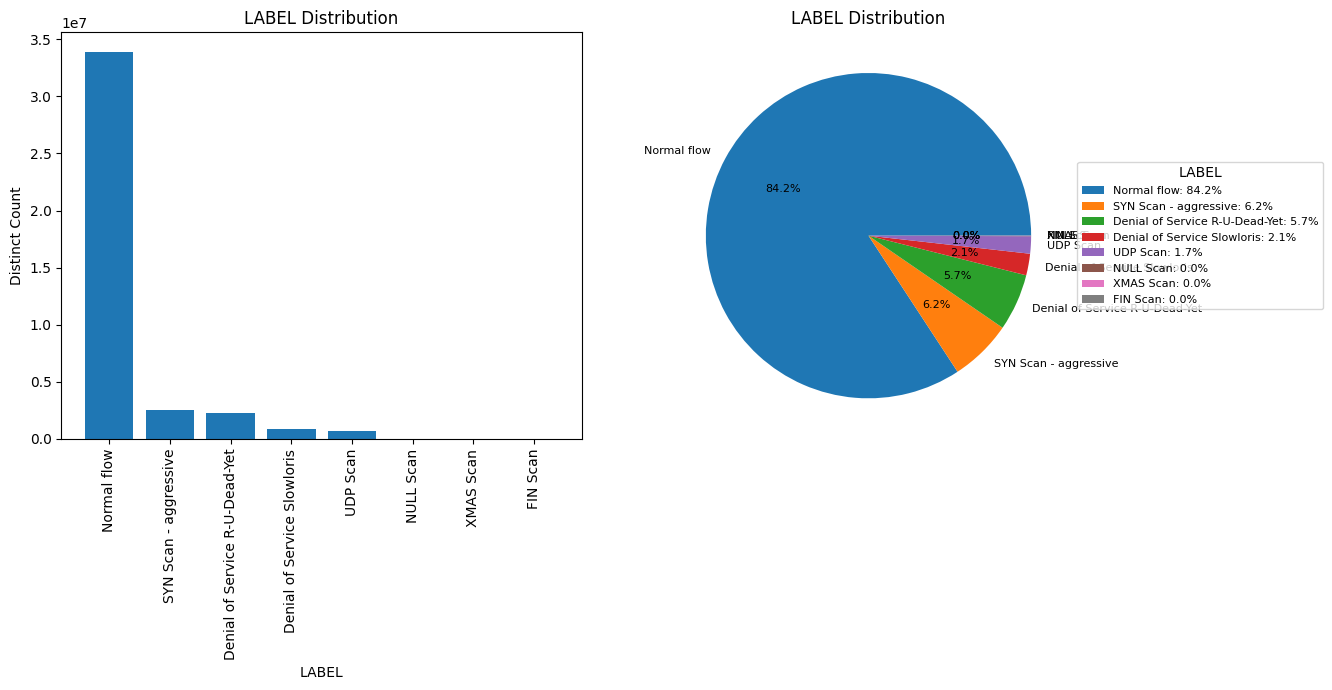

In [55]:
grouped_data = data_frame['LABEL'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

ax1.bar(grouped_data.index, grouped_data.values)
ax1.set_xlabel('LABEL')
ax1.set_ylabel('Distinct Count')
ax1.set_title('LABEL Distribution')
ax1.tick_params(axis='x', rotation=90)

wedges, texts, autotexts = ax2.pie(grouped_data.values, labels=grouped_data.index, autopct='%1.1f%%', textprops={'fontsize': 8})
ax2.set_title('LABEL Distribution')

ax2.legend(wedges, [f"{label}: {pct:.1f}%" for label, pct in zip(grouped_data.index, grouped_data.values / grouped_data.values.sum() * 100)], 
           title="LABEL", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=8)

plt.tight_layout()
plt.show()

In [56]:
categorical_columns = data_frame.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_columns = data_frame.select_dtypes(include=['number']).columns.tolist()

print("Categorical Features:")
print(categorical_columns)

print("\nNumerical Features:")
print(numerical_columns)

Categorical Features:
['LABEL']

Numerical Features:
['DST_TOS', 'SRC_TOS', 'TCP_WIN_SCALE_OUT', 'TCP_WIN_SCALE_IN', 'TCP_FLAGS', 'TCP_WIN_MAX_OUT', 'PROTOCOL', 'TCP_WIN_MIN_OUT', 'TCP_WIN_MIN_IN', 'TCP_WIN_MAX_IN', 'LAST_SWITCHED', 'TCP_WIN_MSS_IN', 'TOTAL_FLOWS_EXP', 'FIRST_SWITCHED', 'FLOW_DURATION_MILLISECONDS']


In [57]:
normalized_data = data_frame.copy()
numerical_columns = normalized_data.select_dtypes(include=['float64', 'int64']).columns
non_numerical_columns = normalized_data.select_dtypes(exclude=['float64', 'int64']).columns

label_encoder = LabelEncoder()
normalized_data[non_numerical_columns] = normalized_data[non_numerical_columns].apply(lambda col: label_encoder.fit_transform(col.astype(str)))

scaler = StandardScaler() 
normalized_data[numerical_columns] = scaler.fit_transform(normalized_data[numerical_columns])

normalized_data.head()

,DST_TOS,SRC_TOS,TCP_WIN_SCALE_OUT,TCP_WIN_SCALE_IN,TCP_FLAGS,TCP_WIN_MAX_OUT,PROTOCOL,TCP_WIN_MIN_OUT,TCP_WIN_MIN_IN,TCP_WIN_MAX_IN,LAST_SWITCHED,TCP_WIN_MSS_IN,TOTAL_FLOWS_EXP,FIRST_SWITCHED,FLOW_DURATION_MILLISECONDS,LABEL
0,-0.153681,-0.176386,-0.278971,-0.32559,0.431500,-0.264100,-0.335656,-0.263830,-0.310821,-0.312604,-2.001036,2.229323,-1.061983,-2.001025,-0.280399,4
1,-0.153681,1.632896,-0.278971,-0.32559,-2.116290,-0.264100,-1.702282,-0.263830,-0.368433,-0.370066,-2.001036,-0.451225,-1.061982,-2.001025,-0.280399,4
2,-0.153681,-0.176386,-0.278971,-0.32559,0.778926,-0.101194,-0.335656,-0.100591,-0.361569,-0.363220,-2.001036,-0.451225,-1.061982,-2.001025,-0.278612,4
3,-0.153681,1.632896,-0.278971,3.45332,-1.884673,-0.264100,-0.335656,-0.263830,0.092460,0.089629,-2.001036,2.192603,-1.061982,-2.001025,-0.280399,4
4,-0.153681,-0.176386,-0.278971,-0.32559,1.126352,-0.264100,-0.335656,-0.263830,-0.340190,-0.341896,-2.001036,-0.451225,-1.061982,-2.001025,-0.280358,4


In [58]:
X = normalized_data.drop(columns=['LABEL'], axis=1)
Y = normalized_data['LABEL']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

Class Distribution:
4    33911170
5     2496814
0     2276947
1      864054
6      692195
3        8497
7        7158
2        6976
Name: LABEL, dtype: int64


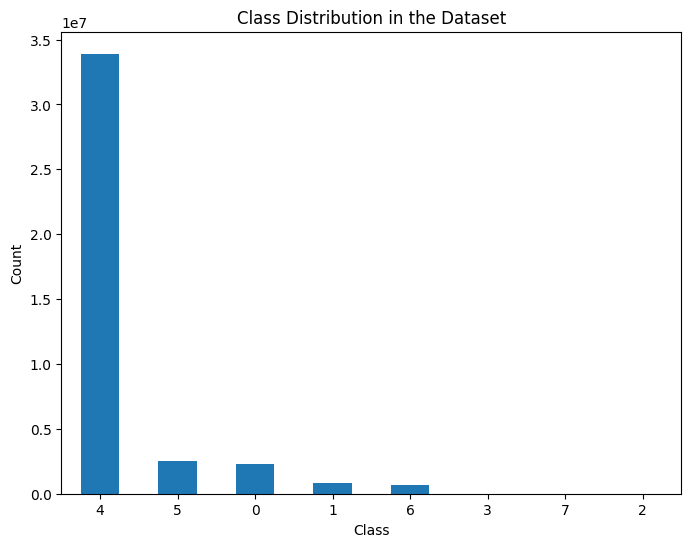

In [59]:
class_distribution = Y.value_counts()

print("Class Distribution:")
print(class_distribution)

plt.figure(figsize=(8,6))
class_distribution.plot(kind='bar')
plt.title('Class Distribution in the Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [ ]:
model_names = ['RandomForest', 'DecisionTree', 'XGBoost', 'BalancedBagging']
accuracy_list = []
f1_list = []
precision_list = []
recall_list = []
training_time_list = []

def evaluate_model(model, model_name):
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    accuracy_list.append(accuracy)
    f1_list.append(f1)
    precision_list.append(precision)
    recall_list.append(recall)
    training_time_list.append(training_time)

    print(f"Model: {model_name}")
    print(f"Training Time: {training_time:.4f} seconds")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("="*60)

models = {
    "RandomForestClassifier": RandomForestClassifier(n_estimators=30),
    "DecisionTreeClassifier": DecisionTreeClassifier(criterion='entropy', max_depth=4, class_weight='balanced'),
    "XGBClassifier": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "BalancedBaggingClassifier": BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100, random_state=42)
}

for model_name, model in models.items():
    evaluate_model(model, model_name)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))

barWidth = 0.2
r1 = np.arange(len(model_names))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

ax1.bar(r1, accuracy_list, color='blue', width=barWidth, edgecolor='grey', label='Accuracy')
ax1.bar(r2, f1_list, color='green', width=barWidth, edgecolor='grey', label='F1 Score')
ax1.bar(r3, precision_list, color='red', width=barWidth, edgecolor='grey', label='Precision')
ax1.bar(r4, recall_list, color='orange', width=barWidth, edgecolor='grey', label='Recall')

ax1.set_xlabel('Models', fontweight='bold')
ax1.set_ylabel('Score', fontweight='bold')
ax1.set_title('Bar Chart of Model Performance', fontweight='bold')
ax1.set_xticks([r + barWidth for r in range(len(model_names))])
ax1.set_xticklabels(model_names)
ax1.legend()

ax2.plot(model_names, accuracy_list, marker='o', label='Accuracy', color='blue', linewidth=2)
ax2.plot(model_names, f1_list, marker='o', label='F1 Score', color='green', linewidth=2)
ax2.plot(model_names, precision_list, marker='o', label='Precision', color='red', linewidth=2)
ax2.plot(model_names, recall_list, marker='o', label='Recall', color='orange', linewidth=2)

ax2.set_xlabel('Models', fontweight='bold')
ax2.set_ylabel('Score', fontweight='bold')
ax2.set_title('Line Graph of Model Performance', fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

In [ ]:
def objective_rf(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)

    # Create the model
    rf_classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Use cross-validation to evaluate the model
    score = cross_val_score(rf_classifier, X_train, y_train, cv=3, scoring='f1_weighted')
    return score.mean()

# 2. Optimize XGBClassifier
def objective_xgb(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    scale_pos_weight = trial.suggest_float('scale_pos_weight', 1, 10)

    # Create the model
    xgb_classifier = XGBClassifier(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        colsample_bytree=colsample_bytree,
        scale_pos_weight=scale_pos_weight,
        use_label_encoder=False,
        random_state=42
    )

    # Use cross-validation to evaluate the model
    score = cross_val_score(xgb_classifier, X_train, y_train, cv=3, scoring='f1_weighted')
    return score.mean()

# 3. Optimize BalancedBaggingClassifier
def objective_bbc(trial):
    # Suggest hyperparameters for the base estimator (DecisionTree)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)

    # Create the base estimator
    base_estimator = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42
    )

    # Suggest hyperparameters for the bagging classifier
    n_estimators = trial.suggest_int('n_estimators', 50, 200)

    # Create the model
    bbc_classifier = BalancedBaggingClassifier(
        base_estimator=base_estimator,
        n_estimators=n_estimators,
        random_state=42
    )

    # Use cross-validation to evaluate the model
    score = cross_val_score(bbc_classifier, X_train, y_train, cv=3, scoring='f1_weighted')
    return score.mean()

# Optimize RandomForest
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=50)

# Optimize XGBClassifier
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=50)

# Optimize BalancedBaggingClassifier
study_bbc = optuna.create_study(direction='maximize')
study_bbc.optimize(objective_bbc, n_trials=50)

# Best hyperparameters
print("Best parameters for RandomForestClassifier: ", study_rf.best_params)
print("Best parameters for XGBClassifier: ", study_xgb.best_params)
print("Best parameters for BalancedBaggingClassifier: ", study_bbc.best_params)